# Demo for nonlinear inverse design of kirigami patterns

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *
import scipy.optimize as scopt
import time

## Define an objective function based on circularity

In [2]:
def boundary_residual_circle(interior_offsets_vector):
    
    global width 
    global height
    global target_phi
    global structure
    global boundary_points
    global corners
    global boundary_offsets
    global dual_bound_inds
    global reduced_dual_bound_inds
    global boundary_points_vector
    
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # update the pattern using the linear inverse design method with the input offset
    structure.linear_inverse_design(boundary_points_vector, corners, interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # get the second contracted state
    deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
    
    # assess the circularity using sum( (r-r_mean)^2 )
    distance_from_center = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-np.mean(deployed_points[reduced_dual_bound_inds,0]))) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-np.mean(deployed_points[reduced_dual_bound_inds,1]))))
    residuals = distance_from_center - np.mean(distance_from_center)
    
    # (Alternative way) assess the circularity using (L^2/(4*pi*A) - 1)^2
    # reduced_dual_bound_inds_shifted = reduced_dual_bound_inds[1:]
    # reduced_dual_bound_inds_shifted.append(reduced_dual_bound_inds[0])
    # edgelengths = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-deployed_points[reduced_dual_bound_inds_shifted,0])) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-deployed_points[reduced_dual_bound_inds_shifted,1])))
    # L = np.sum(edgelengths)
    # pgon = geom.Polygon(zip(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1]))
    # A = pgon.area
    # residuals = L**2/(4*np.pi*A) - 1
    
    return residuals

## Solve for an optimized pattern that gives a square-to-circle transformation

In [3]:
# set the pattern size
width = 8 
height = 8

# create a square kirigami structure and get the required information for the optimization
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]
boundary_points_vector = np.vstack(boundary_points)

# also get the reconfigured boundary node indices for optimizing the second contracted shape
structure.linear_inverse_design(boundary_points_vector, corners, np.reshape(np.zeros(width*height), (height, width)), boundary_offsets)
structure.make_hinge_contact_points()
deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
dual_bound_inds = []
for bound_ind in range(4):
    dual_bound_inds.extend(structure.get_dual_boundary_node_inds(bound_ind))
reduced_dual_bound_inds = []
for i, ind in enumerate(dual_bound_inds):    
    next_i = (i+1) % len(dual_bound_inds)    
    next_ind = dual_bound_inds[next_i]    
    if norm(deployed_points[ind] - deployed_points[next_ind]) > 1e-10:
        reduced_dual_bound_inds.append(ind)
        
# perform the nonlinear optimization to find an optimal set of offset parameters 
# that gives a square-to-circle transformation
print("Optimization starts...")
start = time.time()
result = scopt.least_squares(boundary_residual_circle, np.zeros(width*height),bounds=(-np.ones(width*height),np.inf),xtol = 1e-4,verbose=2)
end = time.time()
print("Finished.")
print('Time taken = ' + str(end - start) + ' seconds')
print('Cost = ' + str(result.cost))
print('Optimal offset = ')
print(result.x)

Optimization starts...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.3573e+00                                    1.03e+00    
       1              2         3.4055e+00      2.95e+00       1.00e+00       6.57e-01    
       2              3         9.3264e-01      2.47e+00       1.96e+00       2.59e-01    
       3              5         5.0030e-01      4.32e-01       7.11e-01       9.97e-02    
       4              6         3.4032e-01      1.60e-01       1.48e+00       2.46e-01    
       5              7         3.2039e-01      1.99e-02       1.50e+00       1.14e+00    
       6              8         1.5851e-01      1.62e-01       3.76e-01       1.99e-01    
       7              9         1.3786e-01      2.06e-02       7.53e-01       4.06e-01    
       8             10         1.2106e-01      1.68e-02       8.36e-01       3.72e-01    
       9             11         1.0811e-01      1.30e-02       7.62

## Plot the optimized pattern

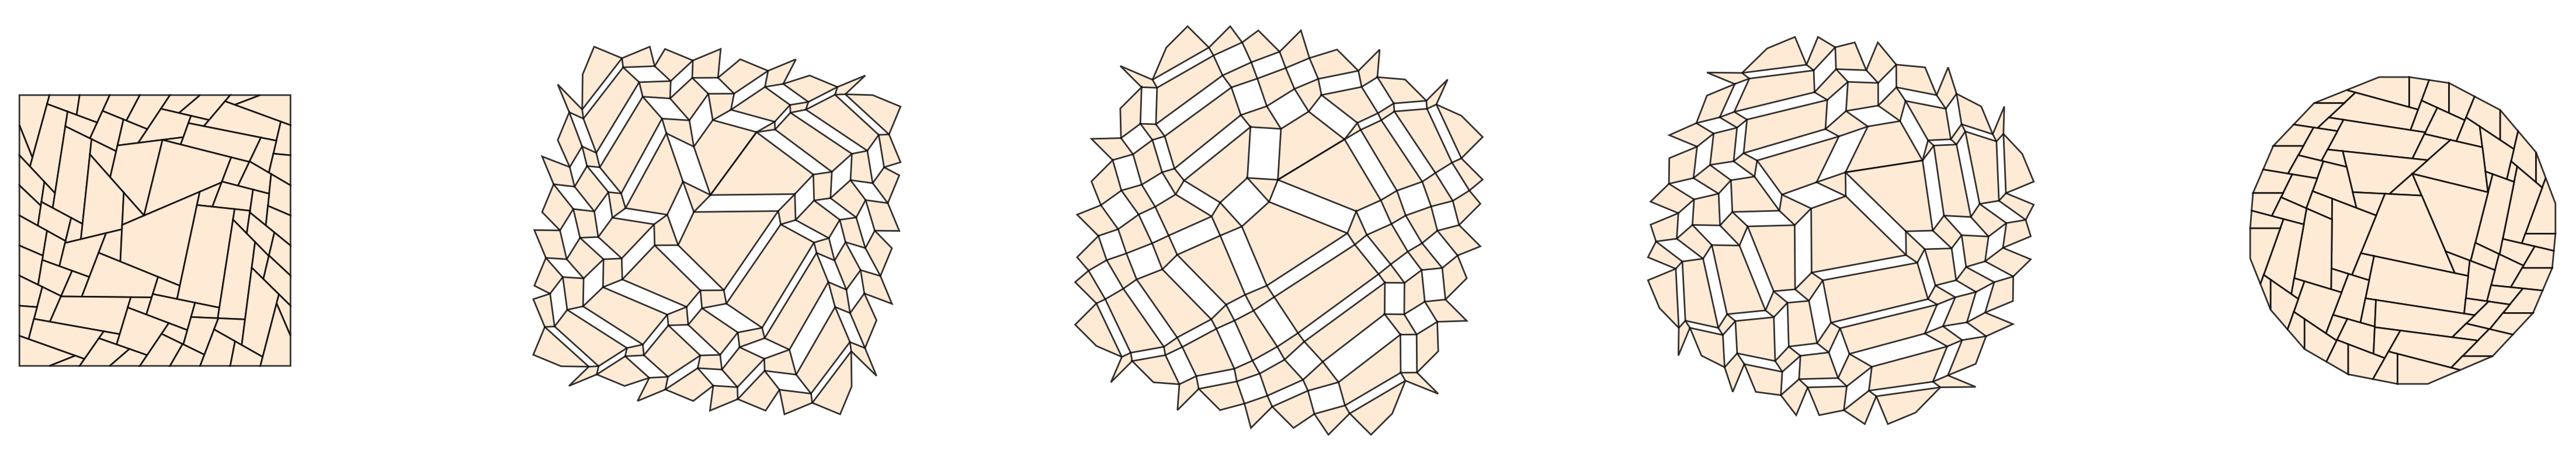

In [4]:
interior_offsets = np.reshape(result.x, (height,width)) # optimal offsets
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets, boundary_offsets)
structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()

num_frames = 5
phis = np.linspace(np.pi, 0, num_frames)

panel_size = 10
fig, axs = plt.subplots(1, num_frames, figsize=(1.2*panel_size*num_frames, panel_size), sharey=True)

for ax_ind, phi in enumerate(phis):
    
    deployed_points, deployed_hinge_contact_points = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)
    
    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2
    
    plot_structure(deployed_points, structure.quads, structure.linkages, axs[ax_ind])
    axs[ax_ind].set_aspect('equal')
    
#     write_obj('Example_square-to-circle_' + str(ax_ind) + '.obj', deployed_points, structure.quads)

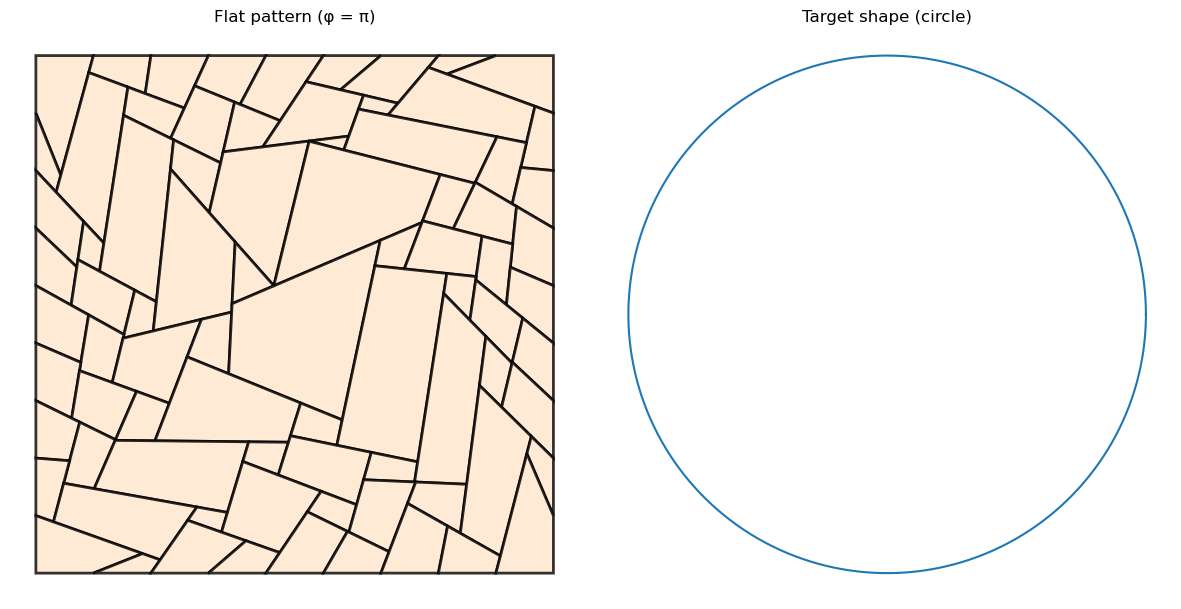

/tmp/ipykernel_13464/2304868060.py:77: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fname))


Saved animation ➜ square_to_circle.gif


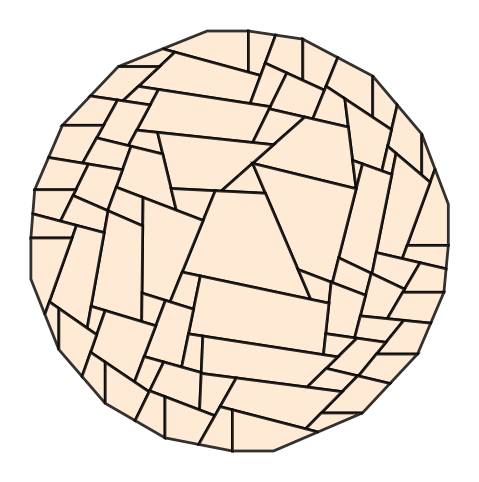

In [5]:
# %% [markdown]
# ## Show target vs. initial pattern, then create & save a GIF of the deployment

# %%
import matplotlib.pyplot as plt
from matplotlib import animation
import imageio
import os

# ---------- 1. Reference figure: target circle & undeployed pattern ----------
fig_ref, ax_ref = plt.subplots(1, 2, figsize=(12, 6))

# (left) undeployed pattern at phi = π
undeployed_pts, _ = structure.layout(phi=np.pi)
plot_structure(undeployed_pts, structure.quads, structure.linkages, ax_ref[0])
ax_ref[0].set_title("Flat pattern (φ = π)")
ax_ref[0].set_aspect('equal')
ax_ref[0].axis('off')

# (right) ideal target: unit circle
theta = np.linspace(0, 2*np.pi, 400)
ax_ref[1].plot(np.cos(theta), np.sin(theta))
ax_ref[1].set_title("Target shape (circle)")
ax_ref[1].set_aspect('equal')
ax_ref[1].axis('off')

plt.tight_layout()
plt.show()

# ---------- 2. Build animation frames ----------
num_frames = 40         # finer sweep for smoother animation
phis_anim = np.linspace(np.pi, 0, num_frames)

fig_anim, ax_anim = plt.subplots(figsize=(6, 6))
ax_anim.set_aspect('equal')
ax_anim.axis('off')

def init():
    ax_anim.clear()
    ax_anim.set_aspect('equal')
    ax_anim.axis('off')
    return []

def animate(i):
    phi = phis_anim[i]
    ax_anim.clear()
    ax_anim.set_aspect('equal')
    ax_anim.axis('off')

    pts, _ = structure.layout(phi)
    # recentre
    pts = rotate_points(pts, np.array([0, 0]), -(np.pi - phi)/2.0)
    pts[:,0] -= (pts[:,0].max() + pts[:,0].min())/2
    pts[:,1] -= (pts[:,1].max() + pts[:,1].min())/2

    plot_structure(pts, structure.quads, structure.linkages, ax_anim)
    return []

ani = animation.FuncAnimation(fig_anim, animate, init_func=init,
                              frames=num_frames, interval=80, blit=True)

# ---------- 3. Save as GIF ----------
# First dump frames to PNGs (works reliably everywhere)
tmp_dir = "_tmp_frames"
os.makedirs(tmp_dir, exist_ok=True)
frame_files = []

for i in range(num_frames):
    animate(i)
    fname = os.path.join(tmp_dir, f"frame_{i:03d}.png")
    fig_anim.savefig(fname, bbox_inches="tight", pad_inches=0.05)
    frame_files.append(fname)

# stitch into GIF (6 fps → ~0.167 s per frame)
with imageio.get_writer("square_to_circle.gif", mode="I", duration=0.167, loop=0) as writer:
    for fname in frame_files:
        writer.append_data(imageio.imread(fname))

# clean up
for fname in frame_files:
    os.remove(fname)
os.rmdir(tmp_dir)

print("Saved animation ➜ square_to_circle.gif")



💓  Optimising for heart target …
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8103e+02                                    2.28e+01    
       1              2         9.1378e+02      6.73e+01       1.00e+00       1.46e+01    
       2              3         8.4871e+02      6.51e+01       2.00e+00       8.28e+00    
       3              4         8.0902e+02      3.97e+01       1.97e+00       6.37e+00    
       4              5         7.4613e+02      6.29e+01       3.95e+00       5.14e+00    
       5              6         6.6192e+02      8.42e+01       8.09e+00       8.40e+00    
       6              7         6.3096e+02      3.10e+01       3.29e+00       2.02e+03    
       7             10         6.3096e+02      0.00e+00       0.00e+00       2.02e+03    
`xtol` termination condition is satisfied.
Function evaluations 10, initial cost 9.8103e+02, final cost 6.3096e+02, first-order optimality 2.02e+03

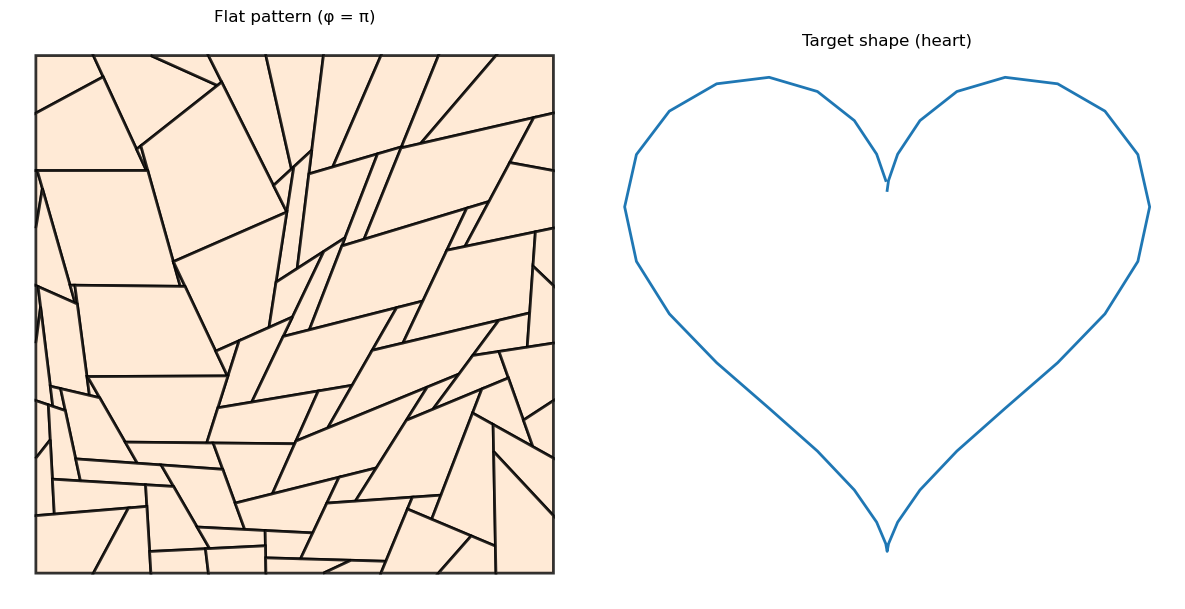

/tmp/ipykernel_13464/532579058.py:125: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  for fn in pngs: w.append_data(imageio.imread(fn))


✅  Saved ➜ square_to_heart.gif


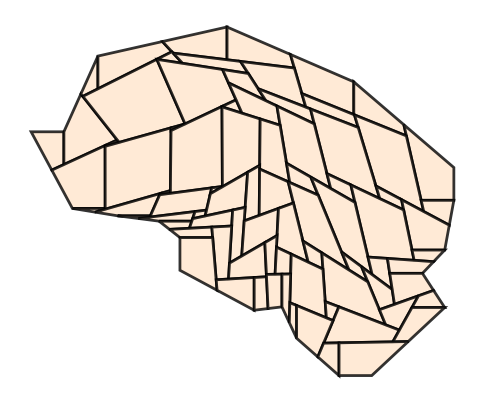

In [9]:
# %% [markdown]
# ## 🔄  Inverse design for a heart-shaped contraction + animation

# %%
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from matplotlib import animation
import imageio, os, shutil, time

# ------------------------------------------------------------------
# 1.  Target geometry: parametric heart curve,
#     re-sampled to match the number of dual-boundary vertices
# ------------------------------------------------------------------
num_target_pts = len(reduced_dual_bound_inds)
t = np.linspace(0, 2*np.pi, num_target_pts, endpoint=False)

# classical cardioid-like heart (scaled later)
x_heart = 16*np.sin(t)**3
y_heart = 13*np.cos(t) - 5*np.cos(2*t) - 2*np.cos(3*t) - np.cos(4*t)

target_points_raw = np.vstack([x_heart, y_heart]).T
# isotropically scale so its RMS radius is 1 (gives optimizer a sensible scale)
target_points_raw -= target_points_raw.mean(axis=0)
target_points_raw /= np.sqrt((target_points_raw**2).sum(axis=1)).mean()

# make it global so the residual can see it
target_points = target_points_raw.copy()           # <<< global

# ------------------------------------------------------------------
# 2.  Residual function: match every dual-boundary node to the target point
#     (up to a uniform scale and translation, which we strip out)
# ------------------------------------------------------------------
def boundary_residual_heart(interior_offsets_vector):
    global width, height, structure
    global boundary_points_vector, corners, boundary_offsets
    global reduced_dual_bound_inds, target_points
    
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # forward solve
    structure.linear_inverse_design(boundary_points_vector, corners,
                                    interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()
    deployed_pts, _ = structure.layout(phi=0.0)
    
    # extract, centre
    P = deployed_pts[reduced_dual_bound_inds]
    P -= P.mean(axis=0)
    T = target_points.copy()
    
    # best uniform scale (no rotation –  heart has clear orientation already)
    scale = np.linalg.norm(P) / np.linalg.norm(T)
    residuals = (P - scale*T).ravel()
    return residuals

# ------------------------------------------------------------------
# 3.  Optimise interior offsets
# ------------------------------------------------------------------
print("\n💓  Optimising for heart target …")
t0 = time.time()
result = scopt.least_squares(boundary_residual_heart,
                             x0=np.zeros(width*height),
                             bounds=(-np.ones(width*height), np.inf),
                             xtol=1e-4, verbose=2)
print(f"… done in {time.time()-t0:.1f}s, cost = {result.cost:.3e}")

# push optimal offsets back into structure for visualisation
opt_offsets = np.reshape(result.x, (height, width))
structure.linear_inverse_design(boundary_points_vector, corners,
                                opt_offsets, boundary_offsets)
structure.assign_node_layers(); structure.assign_quad_genders()
structure.make_hinge_contact_points()

# ------------------------------------------------------------------
# 4.  Plot reference figure: flat pattern & target heart
# ------------------------------------------------------------------
fig_ref, ax_ref = plt.subplots(1, 2, figsize=(12, 6))

# (left) undeployed pattern at φ = π
flat_pts, _ = structure.layout(phi=np.pi)
plot_structure(flat_pts, structure.quads, structure.linkages, ax_ref[0])
ax_ref[0].set_title("Flat pattern (φ = π)")
ax_ref[0].set_aspect("equal"); ax_ref[0].axis("off")

# (right) target heart
ax_ref[1].plot(target_points[:,0], target_points[:,1], linewidth=2)
ax_ref[1].set_title("Target shape (heart)")
ax_ref[1].set_aspect("equal"); ax_ref[1].axis("off")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------------
# 5.  Build animation frames (flat ➜ heart) & save GIF
# ------------------------------------------------------------------
num_frames = 40
phis_anim = np.linspace(np.pi, 0, num_frames)

fig_anim, ax_anim = plt.subplots(figsize=(6, 6))
ax_anim.set_aspect("equal"); ax_anim.axis("off")

def draw_state(phi):
    ax_anim.clear(); ax_anim.set_aspect("equal"); ax_anim.axis("off")
    P, _ = structure.layout(phi)
    P = rotate_points(P, np.array([0, 0]), -(np.pi - phi)/2)
    P[:,0] -= (P[:,0].max()+P[:,0].min())/2
    P[:,1] -= (P[:,1].max()+P[:,1].min())/2
    plot_structure(P, structure.quads, structure.linkages, ax_anim)

def init(): draw_state(phis_anim[0]); return []
def animate(i): draw_state(phis_anim[i]); return []

ani = animation.FuncAnimation(fig_anim, animate, init_func=init,
                              frames=num_frames, interval=90, blit=True)

tmp_dir = "_tmp_frames_heart"
os.makedirs(tmp_dir, exist_ok=True)
pngs = []
for i, phi in enumerate(phis_anim):
    draw_state(phi)
    fn = os.path.join(tmp_dir, f"frame_{i:03d}.png")
    fig_anim.savefig(fn, bbox_inches="tight", pad_inches=0.0)
    pngs.append(fn)

with imageio.get_writer("square_to_heart.gif", mode="I", duration=0.15, loop=0) as w:
    for fn in pngs: w.append_data(imageio.imread(fn))

shutil.rmtree(tmp_dir)       # clean
print("✅  Saved ➜ square_to_heart.gif")

# %%


💓  Optimising offsets …
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8900e+02                                    9.92e+00    
       1              2         4.7331e+02      1.57e+01       1.23e+00       6.67e+00    
       2              3         4.6359e+02      9.72e+00       2.18e+00       1.78e+02    
       3              4         4.4179e+02      2.18e+01       2.11e+00       2.51e+01    
       4              5         3.9296e+02      4.88e+01       4.20e+00       7.40e+01    
       5              7         2.7595e+02      1.17e+02       9.52e-01       7.27e+01    
       6              9         2.0235e+02      7.36e+01       5.19e-01       6.78e+01    
       7             12         1.9346e+02      8.90e+00       6.11e-02       3.64e+02    
       8             18         1.9346e+02      0.00e+00       0.00e+00       3.64e+02    
`xtol` termination condition is satisfied.
Function evaluations 18

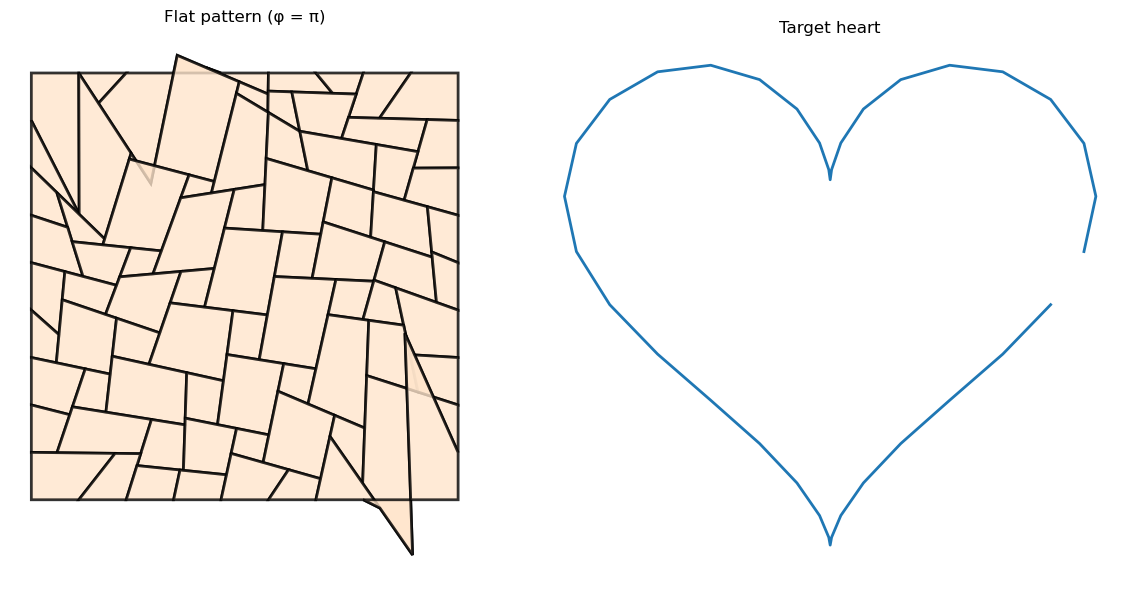

/tmp/ipykernel_13464/293032021.py:150: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(fn))


✅  Saved ➜ square_to_heart.gif


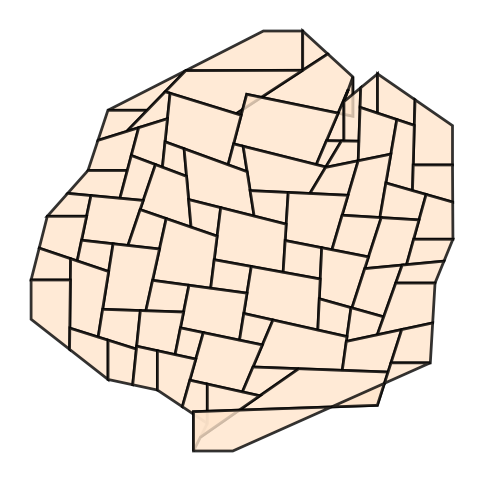

In [7]:
# %% [markdown]
# ## 💓  Square-to-Heart inverse design  – ordering + similarity-transform fix

# %%
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import imageio, os, shutil, time
from scipy.linalg import svd
import scipy.optimize as scopt

# ------------------------------------------------------------------------------------
# 0. (Optional) use a finer grid – the heart needs more DoFs than the circle
# ------------------------------------------------------------------------------------
# width, height = 6, 6     # uncomment if you want to rebuild the structure with 6×6 cells

# ------------------------------------------------------------------------------------
# 1.  Robust ordering of dual-boundary nodes
#     – sort by polar angle around the centroid so we are guaranteed CCW ordering
# ------------------------------------------------------------------------------------
structure.make_hinge_contact_points()
deployed_zero, _ = structure.layout(phi=0.0)            # any offsets – ordering only
dual_pts = deployed_zero[reduced_dual_bound_inds]
centroid = dual_pts.mean(axis=0)
angles = np.mod(np.arctan2(dual_pts[:,1]-centroid[1],
                           dual_pts[:,0]-centroid[0]), 2*np.pi)
order = np.argsort(angles)                              # CCW starting from +x axis
reduced_dual_bound_inds = [reduced_dual_bound_inds[i] for i in order]

# ------------------------------------------------------------------------------------
# 2.  Target heart curve with matching ordering & length
# ------------------------------------------------------------------------------------
N = len(reduced_dual_bound_inds)
t = np.linspace(0, 2*np.pi, N, endpoint=False)

xH = 16*np.sin(t)**3
yH = 13*np.cos(t) - 5*np.cos(2*t) - 2*np.cos(3*t) - np.cos(4*t)
heart = np.vstack([xH, yH]).T
heart -= heart.mean(axis=0)                      # centre
heart /= np.sqrt((heart**2).sum(1)).mean()       # scale to unit RMS radius

# **Sort** by the same polar angle rule so indices line up
angles_H = np.mod(np.arctan2(heart[:,1], heart[:,0]), 2*np.pi)
heart = heart[np.argsort(angles_H)]

target_points = heart.copy()      # global for residual

# ------------------------------------------------------------------------------------
# 3.  Helper: best similarity transform (rotation R, scale s)  via SVD
# ------------------------------------------------------------------------------------
def best_similarity_transform(P, T):
    """
    P,T: (N,2) already centred.  Returns 2×2 rotation R, scalar s.
    """
    C = T.T @ P
    U, _, Vt = svd(C)
    R = U @ Vt
    if np.linalg.det(R) < 0:      # proper rotation
        R[:,1] *= -1
    s = np.trace(C @ R) / np.sum(T**2)
    return R, s

# ------------------------------------------------------------------------------------
# 4.  Residual with full similarity transform
# ------------------------------------------------------------------------------------
def residual_heart(offset_vec):
    interior_offsets = offset_vec.reshape(height, width)

    structure.linear_inverse_design(boundary_points_vector, corners,
                                    interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()
    P, _ = structure.layout(phi=0.0)
    P = P[reduced_dual_bound_inds]

    # centre both point sets
    P -= P.mean(0)
    T = target_points

    # similarity transform
    R, s = best_similarity_transform(P, T)
    residuals = (P - (s * (R @ T.T).T)).ravel()
    return residuals

# ------------------------------------------------------------------------------------
# 5.  Non-linear least squares optimisation
# ------------------------------------------------------------------------------------
print("💓  Optimising offsets …")
t0 = time.time()
result = scopt.least_squares(residual_heart,
                             x0=np.zeros(width*height),
                             bounds=(-2*np.ones(width*height), np.inf),   # allow larger negative offsets
                             xtol=1e-4, verbose=2)
print(f"… done in {time.time()-t0:.1f}s  (cost = {result.cost:.3e})")

opt_offsets = result.x.reshape(height, width)
structure.linear_inverse_design(boundary_points_vector, corners,
                                opt_offsets, boundary_offsets)
structure.assign_node_layers(); structure.assign_quad_genders()
structure.make_hinge_contact_points()

# ------------------------------------------------------------------------------------
# 6.  Reference plot: flat pattern & target heart
# ------------------------------------------------------------------------------------
fig_ref, ax_ref = plt.subplots(1, 2, figsize=(12, 6))

flat_pts, _ = structure.layout(phi=np.pi)
plot_structure(flat_pts, structure.quads, structure.linkages, ax_ref[0])
ax_ref[0].set_title("Flat pattern (φ = π)")
ax_ref[0].set_aspect("equal"); ax_ref[0].axis("off")

ax_ref[1].plot(target_points[:,0], target_points[:,1], linewidth=2)
ax_ref[1].set_title("Target heart")
ax_ref[1].set_aspect("equal"); ax_ref[1].axis("off")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------------------------------
# 7.  Build animation (φ : π ➜ 0) and save GIF
# ------------------------------------------------------------------------------------
num_frames = 50
phis_anim = np.linspace(np.pi, 0, num_frames)

fig_anim, ax_anim = plt.subplots(figsize=(6, 6))
ax_anim.set_aspect("equal"); ax_anim.axis("off")

def draw(phi):
    ax_anim.clear(); ax_anim.set_aspect("equal"); ax_anim.axis("off")
    P, _ = structure.layout(phi)
    P = rotate_points(P, np.array([0, 0]), -(np.pi - phi)/2)
    P[:,0] -= (P[:,0].max()+P[:,0].min())/2
    P[:,1] -= (P[:,1].max()+P[:,1].min())/2
    plot_structure(P, structure.quads, structure.linkages, ax_anim)

def init(): draw(phis_anim[0]); return []
def animate(k): draw(phis_anim[k]); return []

ani = animation.FuncAnimation(fig_anim, animate, init_func=init,
                              frames=num_frames, interval=80, blit=True)

tmp = "_tmp_heart_frames"
os.makedirs(tmp, exist_ok=True)
pngs = []
for k, phi in enumerate(phis_anim):
    draw(phi)
    fn = os.path.join(tmp, f"f{k:03d}.png")
    fig_anim.savefig(fn, bbox_inches="tight", pad_inches=0.0)
    pngs.append(fn)

with imageio.get_writer("square_to_heart.gif", mode="I", duration=0.12) as w:
    for fn in pngs:
        w.append_data(imageio.imread(fn))
shutil.rmtree(tmp)

print("✅  Saved ➜ square_to_heart.gif")
